# Keras WGAN
An impelemtation in Keras to Generative Adversariel Network.
The Wasserstein GAN is comprised of a Generator and a Critic. Both parts are build of Fully-Connected architecture.
There are several differences between GAN and WGAN:
- Critic vs Discriminator: while the Discriminator tries to determine wether images are real / fake, the Critic gives it a value that measures the quality or the "realness" of the images. Therefore, WGAN introduces a new loss : wasserstein loss.
- Weight clipping in the critic
- The WGAN labels are -1 and 1, and not 0 and 1
- Usually WGAN is trained using RMSprop and not Adam, like regular GANs
- The critic is trained more than the generator

In [1]:
# imports
from tensorflow import keras
from keras.datasets.mnist import load_data
from keras.layers import Dense, LeakyReLU, ReLU, Input, Reshape, Flatten, BatchNormalization
from keras.models import Model
import numpy as np
from keras.utils import plot_model
from keras.optimizers import RMSprop
from tensorflow.keras.constraints import Constraint
from keras import backend

lr_g = 2e-5
lr_d = 5e-5

Using TensorFlow backend.


# Data
Load and pre-process the dataset (MNIST)

In [2]:
(X_train,_),(X_test, _) = load_data()
ds_train_size, h, w = X_train.shape
ds_test_size, _, _ = X_test.shape
# normalize datasets
X_train = (X_train / 255.)  # [0,1]
X_train = X_train * 2.      # [0,2]
X_train = X_train - 1.      # [-1,1]

X_test = (X_test / 255.)  # [0,1]
X_test = X_test * 2.      # [0,2]
X_test = X_test - 1.      # [-1,1]


# WGAN Auxilary methods
- Clip constraint for the critic
- Wasserstein loss

In [3]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}


const = ClipConstraint(0.01)

In [4]:
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

# Generator
Define the Generator with FC architecture, using functional API coding.

Generator's input : a noise tensor

Generator's output: a batch of generated images

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8448      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 512)               0 

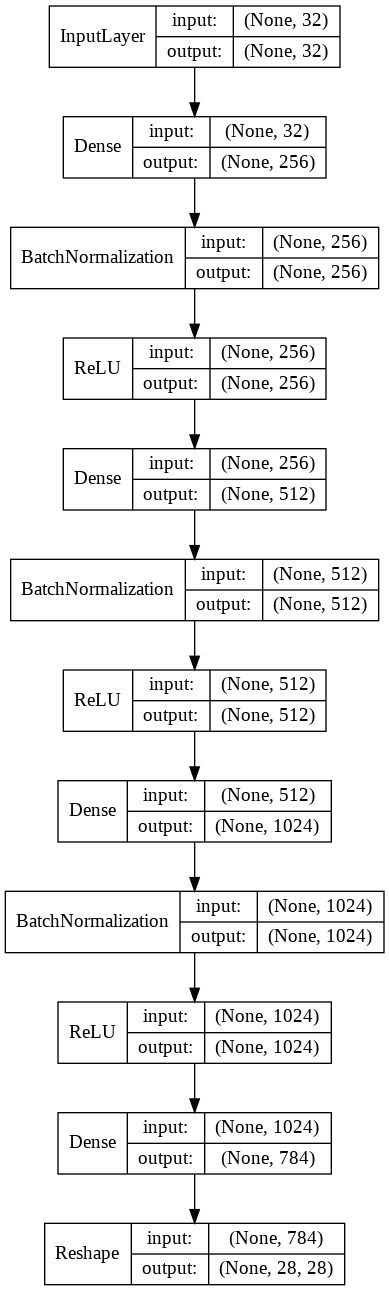

In [5]:
NOISE_DIM = 32
g_input = Input((NOISE_DIM,))
x = Dense(256)(g_input)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dense(h*w,activation='tanh')(x)
g_output = Reshape((h,w))(x)

G = Model(g_input, g_output)
G.name = 'Generator'
G.summary()

plot_model(G, to_file='G.png', show_shapes=True, show_layer_names=False)

# Critic
Define the critic using keras functional API coding.

Critic's input: batches of images (real / fake)

Critic's output: the "realness" of the images

Model: "Critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1568)              1230880   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1568)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 784)               1230096   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 785  

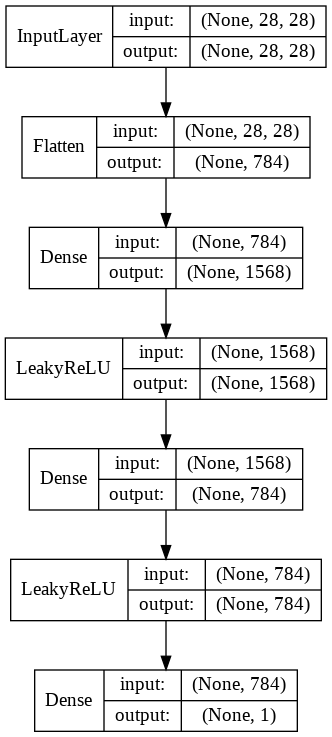

In [11]:
opt = RMSprop(learning_rate=lr_d)

C_input = Input((h,w,))
x = Flatten()(C_input)
x = Dense(h*w*2,kernel_constraint=const)(x)
x = LeakyReLU()(x)
x = Dense(h*w,kernel_constraint=const)(x)
x = LeakyReLU()(x)
C_output = Dense(1)(x)

C = Model(C_input, C_output)
C.compile(optimizer=opt,loss=wasserstein_loss,metrics=['accuracy'])
C.name = 'Critic'
C.summary()

plot_model(C, to_file='C.png', show_shapes=True, show_layer_names=False)

# Define the GAN model
Create a model that consists of the Generator and the Critic. The weights for the critic's model will be not trainable - an implementation trick that enables the sequential training of the models.

In [12]:
opt = RMSprop(learning_rate=lr_g)
C.trainable = False
G.trainable = True
GAN_input = Input((NOISE_DIM,))
fake = G(GAN_input)
GAN_output = C(fake)

GAN = Model(GAN_input, GAN_output)
GAN.name = 'GAN'
GAN.summary()

plot_model(GAN,to_file='GAN.png', show_layer_names=True, show_shapes=True)

GAN.compile(opt,loss=wasserstein_loss,metrics=['accuracy'])

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32)                0         
_________________________________________________________________
Generator (Model)            (None, 28, 28)            1476112   
_________________________________________________________________
Critic (Model)               (None, 1)                 2461761   
Total params: 3,937,873
Trainable params: 1,472,528
Non-trainable params: 2,465,345
_________________________________________________________________


# Training process
In adversarial training, the critic is trained to measure the realness of the real and fake samples. the Generator is trained to 'fool' the critic.

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results for epoch 0


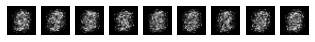

results for epoch 1


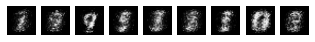

results for epoch 2


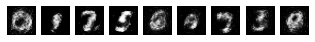

results for epoch 3


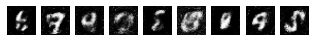

results for epoch 4


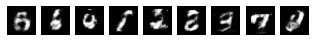

results for epoch 5


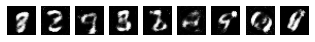

results for epoch 6


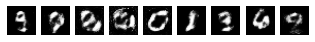

results for epoch 7


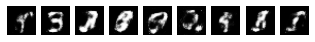

results for epoch 8


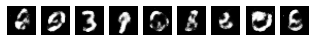

results for epoch 9


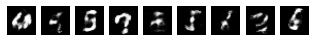

results for epoch 10


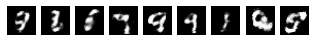

results for epoch 11


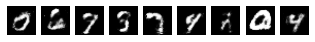

results for epoch 12


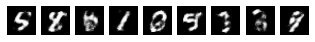

results for epoch 13


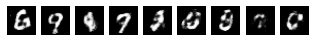

results for epoch 14


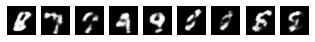

results for epoch 15


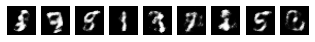

results for epoch 16


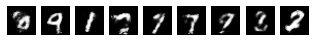

results for epoch 17


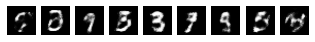

results for epoch 18


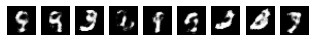

results for epoch 19


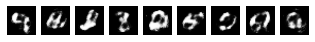

results for epoch 20


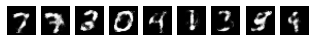

results for epoch 21


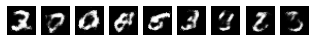

results for epoch 22


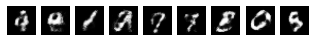

results for epoch 23


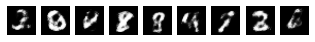

results for epoch 24


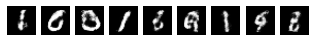

results for epoch 25


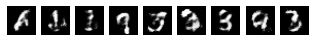

results for epoch 26


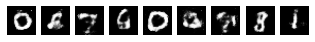

results for epoch 27


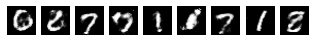

results for epoch 28


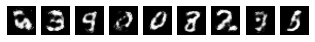

results for epoch 29


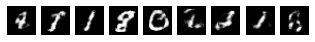

results for epoch 30


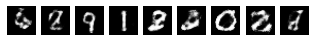

results for epoch 31


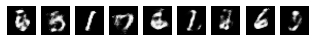

results for epoch 32


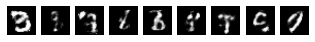

results for epoch 33


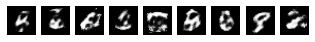

results for epoch 34


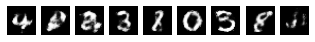

results for epoch 35


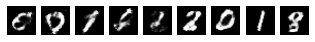

results for epoch 36


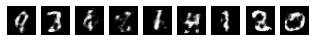

results for epoch 37


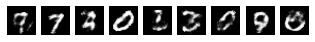

results for epoch 38


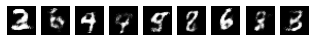

results for epoch 39


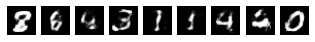

results for epoch 40


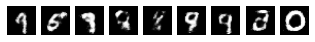

results for epoch 41


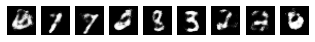

results for epoch 42


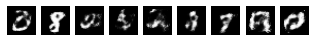

results for epoch 43


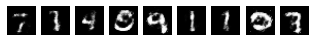

results for epoch 44


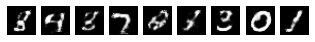

results for epoch 45


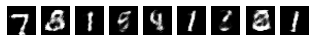

results for epoch 46


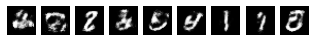

results for epoch 47


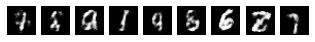

results for epoch 48


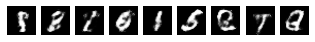

results for epoch 49


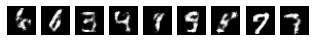

In [9]:
EPOCHS = 50
BATCH_SIZE = 64

np.random.shuffle(X_train)

for epoch in range(EPOCHS):
  for step in range(ds_train_size//BATCH_SIZE):
    # train C on real samples
    for _ in range(10):
      idxs = np.random.randint(low=0,high=ds_train_size,size=BATCH_SIZE)
      x_real = X_train[idxs, :]
      C_loss_real, _ = C.train_on_batch(x=x_real,y=-1. * np.ones(shape=(BATCH_SIZE)))
      # train D on fake samples
      Z = np.random.randn(BATCH_SIZE, NOISE_DIM,)
      x_fake = G.predict(Z)
      C_loss_fake, _ = C.train_on_batch(x=x_fake,y=1. * np.ones(shape=(BATCH_SIZE)))
    # train G
    Z = np.random.randn(BATCH_SIZE, NOISE_DIM)
    G_loss = GAN.train_on_batch(x=Z, y=-1. * np.ones(shape=(BATCH_SIZE)))
  # plot samples
  Z = np.random.randn(10, NOISE_DIM,)
  x_fake = G.predict(Z)
  print(f'results for epoch {epoch}')
  plt.figure()
  for i in range(1,10):
    plt.subplot(1,10,i)
    plt.imshow(x_fake[i,:], cmap='gray')
    plt.axis('off')
  plt.show()

# Visualize Results

results for epoch 49


<Figure size 432x288 with 0 Axes>

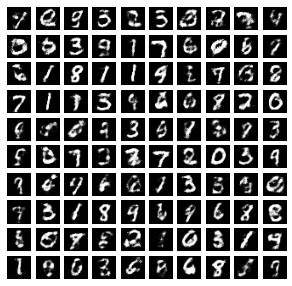

In [10]:
  Z = np.random.randn(101, NOISE_DIM,)
  x_fake = G.predict(Z)
  print(f'results for epoch {epoch}')
  plt.figure()
  plt.figure(figsize=(5,5))
  for i in range(1,101):
    plt.subplot(10,10,i)
    plt.imshow(x_fake[i-1,:], cmap='gray')
    plt.axis('off')
  plt.show()